In [0]:
%tensorflow_version 2.x
!pip install -q tensorflow-quantum
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

In [0]:
a, b = sympy.symbols('a b')

In [7]:
a

a

In [8]:
b

b

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


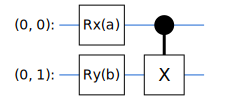

In [11]:
# Create two qubits
q0, q1 = cirq.GridQubit.rect(1, 2)

# Create a circuit on these qubits using the parameters you created above.
circuit = cirq.Circuit(
    cirq.rx(a).on(q0),
    cirq.ry(b).on(q1), cirq.CNOT(control=q0, target=q1))

SVGCircuit(circuit)

In [14]:
# Calculate a state vector with a=0.5 and b=-0.5
resolver = cirq.ParamResolver({a: 0.5, b: -0.5})
output_state_vector = cirq.Simulator().simulate(circuit, resolver).final_state
output_state_vector

array([ 0.9387913 +0.j        , -0.23971277+0.j        ,
        0.        +0.06120872j,  0.        -0.23971277j], dtype=complex64)

In [15]:
z0 = cirq.Z(q0)

qubit_map = {q0: 0, q1: 1}
z0.expectation_from_wavefunction(output_state_vector, qubit_map).real

0.8775825500488281

In [16]:
z0x1 = 0.5 * z0 + cirq.X(q1)

z0x1.expectation_from_wavefunction(output_state_vector, qubit_map).real

-0.04063427448272705

In [17]:
# Rank 1 tensor containing 1 circuit.
circuit_tensor = tfq.convert_to_tensor([circuit])

print(circuit_tensor.shape)
print(circuit_tensor.dtype)

(1,)
<dtype: 'string'>


In [18]:
# Rank 1 tensor containing 2 Pauli operators.
pauli_tensor = tfq.convert_to_tensor([z0, z0x1])
pauli_tensor.shape

TensorShape([2])

In [0]:
batch_vals = np.array(np.random.uniform(0, 2 * np.pi, (5, 2)), dtype=np.float32)

In [26]:
cirq_results = []
cirq_simulator = cirq.Simulator()

for vals in batch_vals:
    resolver = cirq.ParamResolver({a: vals[0], b: vals[1]})
    final_state = cirq_simulator.simulate(circuit, resolver).final_state
    cirq_results.append(
        [z0.expectation_from_wavefunction(final_state, {
            q0: 0,
            q1: 1
        }).real])

print('cirq batch results: \n {}'.format(np.array(cirq_results)))

cirq batch results: 
 [[ 0.01191249]
 [ 0.94867182]
 [ 0.51924688]
 [-0.65617692]
 [ 0.98844975]]


In [27]:
tfq.layers.Expectation()(circuit,
                         symbol_names=[a, b],
                         symbol_values=batch_vals,
                         operators=z0)

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[ 0.01191243],
       [ 0.9486718 ],
       [ 0.5192468 ],
       [-0.65617675],
       [ 0.9884497 ]], dtype=float32)>

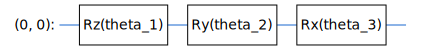

In [28]:
# Parameters that the classical NN will feed values into
control_params = sympy.symbols('theta_1 theta_2 theta_3')

# Create the parameterized circuit.
qubit = cirq.GridQubit(0, 0)
model_circuit = cirq.Circuit(
    cirq.rz(control_params[0])(qubit),
    cirq.ry(control_params[1])(qubit),
    cirq.rx(control_params[2])(qubit))

SVGCircuit(model_circuit)

In [0]:
# Define controller network

# the classical neural network layers.
controller = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(3)
])

In [31]:
# Given a batch of commands, the controller outputs a batch of
# control signals for the controlled circuit.
# The controller is randomly initialized so these output are not useful, yet.
controller(tf.constant([[0.0], [1.0]])).numpy()

array([[ 0.        ,  0.        ,  0.        ],
       [-0.05786071,  0.20824674, -0.3152286 ]], dtype=float32)

In [0]:
# This input is the simulated miscalibration that the model will learn to correct.
circuits_input = tf.keras.Input(shape=(),
                               # The circuit-tensor has dtype `tf.string`
                               dtype=tf.string,
                               name='circuit_input')

# Commands will be either `0` or `1`, specifying the state to set the qubit to.
commands_input = tf.keras.Input(shape=(1, ),
                                dtype=tf.dtypes.float32,
                                name='commands_input')

In [0]:
# Apply operations to those inputs, to define the commputation

dense_2 = controller(commands_input)

# TFQ layer for classifcally controlled circuits.
expectation_layer = tfq.layers.ControlledPQC(model_circuit,
                                             # Observe Z
                                             operators=cirq.Z(qubit))
expectation = expectation_layer([circuits_input, dense_2])

In [0]:
# Package this compuatation as a `tf.keras.Model`

# The full Keras model is built from out layers.
model = tf.keras.Model(inputs=[circuits_input, commands_input],
                       outputs=expectation)

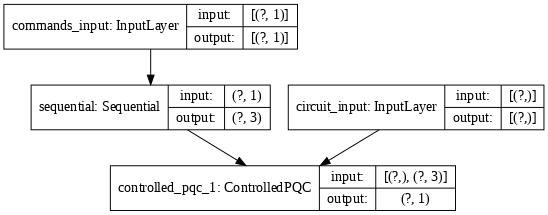

In [39]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=70)

In [0]:
# The command input values to the classical NN.
commands = np.array([[0], [1]], dtype=np.float32)

# The desired Z expectaiton value at output of quantum circuit.
expected_outputs = np.array([[1], [-1]], dtype=np.float32)

In [0]:
# The input-circuit below defines the ranodm miscalibration
# the model will learn to correct.
random_rotations = np.random.uniform(0, 2 * np.pi, 3)
datapoint_circuits = tfq.convert_to_tensor([
    cirq.Circuit(
        cirq.rx(random_rotations[0])(qubit),
        cirq.ry(random_rotations[1])(qubit),
        cirq.rz(random_rotations[2])(qubit))
    ] * 2) # Make two copied of this circuit

In [46]:
datapoint_circuits.shape

TensorShape([2])

In [47]:
model([datapoint_circuits, commands]).numpy()

array([[0.22775443],
       [0.38682213]], dtype=float32)

In [0]:
# Run a standard training process to adjust these values
# towards the `expected_outputs`.
optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
loss = tf.keras.losses.MeanSquaredError()
model.compile(optimizer=optimizer, loss=loss)
history = model.fit(x=[datapoint_circuits, commands],
                    y=expected_outputs,
                    epochs=30,
                    verbose=0)

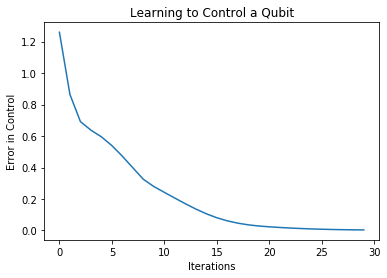

In [49]:
plt.plot(history.history['loss'])
plt.title('Learning to Control a Qubit')
plt.xlabel('Iterations')
plt.ylabel('Error in Control')
plt.show()

In [0]:
# Define inputs.
commands_input = tf.keras.layers.Input(shape=(1),
                                       dtype=tf.dtypes.float32,
                                       name='commands_input')
circuits_input = tf.keras.Input(shape=(),
                                dtype=tf.dtypes.string,
                                name='circuits_input')
operators_input = tf.keras.Input(shape=(1,),
                                 dtype=tf.dtypes.string,
                                 name='operators_input')

In [0]:
controller = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(3)])

In [0]:
dense_2 = controller(commands_input)

# Since you aren't using a PQC or ControlledPQC you must append
# your model circuit onto the datapoint circuit tensor manually.
full_circuit = tfq.layers.AddCircuit()(circuits_input, append=model_circuit)
expectation_output = tfq.layers.Expectation()(full_circuit,
                                              symbol_names=control_params,
                                              symbol_values=dense_2,
                                              operators=operators_input)

# Contruct your Keras model.
two_axis_control_model = tf.keras.Model(
    inputs=[circuits_input, commands_input, operators_input],
    outputs=[expectation_output])

In [0]:
# The operators to measure, for each command.
operator_data = tfq.convert_to_tensor([[cirq.X(qubit)], [cirq.Z(qubit)]])

# The command input values to the classical NN.
commands = np.array([[0], [1]], dtype=np.float32)

# The desired expectation value at output of quantum circuit.
expected_outputs = np.array([[1], [-1]], dtype=np.float32)

In [59]:
optimizer = tf.keras.optimizers.Adam(lr=0.05)

loss = tf.keras.losses.MeanSquaredError()

two_axis_control_model.compile(optimizer=optimizer, loss=loss)

history = two_axis_control_model.fit(
    x=[datapoint_circuits, commands, operator_data],
    y=expected_outputs,
    epochs=30,
    verbose=1)

Train on 2 samples
Epoch 1/30
2/2 [==============================] - 1s 337ms/sample - loss: 0.7628
Epoch 2/30
2/2 [==============================] - 0s 7ms/sample - loss: 0.4598
Epoch 3/30
2/2 [==============================] - 0s 9ms/sample - loss: 0.2637
Epoch 4/30
2/2 [==============================] - 0s 8ms/sample - loss: 0.1541
Epoch 5/30
2/2 [==============================] - 0s 11ms/sample - loss: 0.1029
Epoch 6/30
2/2 [==============================] - 0s 11ms/sample - loss: 0.0861
Epoch 7/30
2/2 [==============================] - 0s 6ms/sample - loss: 0.0890
Epoch 8/30
2/2 [==============================] - 0s 6ms/sample - loss: 0.0925
Epoch 9/30
2/2 [==============================] - 0s 8ms/sample - loss: 0.0904
Epoch 10/30
2/2 [==============================] - 0s 7ms/sample - loss: 0.0852
Epoch 11/30
2/2 [==============================] - 0s 6ms/sample - loss: 0.0807
Epoch 12/30
2/2 [==============================] - 0s 6ms/sample - loss: 0.0781
Epoch 13/30
2/2 [=========

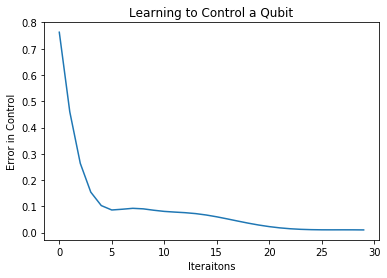

In [60]:
plt.plot(history.history['loss'])
plt.title('Learning to Control a Qubit')
plt.xlabel('Iteraitons')
plt.ylabel('Error in Control')
plt.show()

In [61]:
controller.predict(np.array([0, 1]))

array([[0.8095469 , 0.45488256, 0.26843196],
       [0.45753503, 1.2286007 , 0.71723163]], dtype=float32)